In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # ploting graphs
import collections #dictionary
from nltk.corpus import stopwords
from wordcloud import WordCloud
STOP_WORDS = set(stopwords.words('english'))

In [2]:
train_df=pd.read_csv(r'../input/train.csv')

In [3]:
train_df.head()

,id,App Version Code,App Version Name,Review Text,Review Title,Star Rating
0,b817b0f0-a2f8-4c9d-a5f6-d3fbf8b1d7e9,NaN,NaN,Very bad wallet balance not use.,NaN,1
1,c7844e8f-56c1-487b-ae3e-df2fdf4c1767,43.0,2.30,Froud app i recharge 199 but not done also sen...,NaN,1
2,93ff57f7-9e02-4fa9-b779-3db82b8af0a4,52.0,2.12,Waste to write comments also,Waste no use,2
3,df2dcdef-c09a-4f35-afab-e1231d3fec9a,62.0,2.21,Nice apo,NaN,5
4,11f8f968-4cec-4424-8427-9709ab05b5be,69.0,2.28,Good nice app,NaN,5


In [4]:
test_df=pd.read_csv(r'../input/test.csv')

In [5]:
test_df.head()

,id,App Version Code,App Version Name,Review Text,Review Title
0,bdcb3129-afc1-4608-825f-558fe9c17e2b,78.0,2.37,"Awesome app, all should use it",NaN
1,7518d5c8-5e35-45e2-b29d-cf0996ba9e2f,75.0,2.34,how can i stop notification,NaN
2,b21ca913-ba44-471b-91e1-aaf035379a84,NaN,NaN,"This app is very easy to use , nice graphics ,...",NaN
3,beaaa17d-44af-44c8-ba38-24ba54c3b17d,83.0,2.42,Quite good but felt slow response from cc. Ove...,NaN
4,89d8c4f0-6fe0-4389-b1f8-913ba894c0f1,74.0,2.33,Not getting otp for login since yesterday. Als...,NaN


In [6]:
# shape of train_df
train_df.shape

(5693, 6)

In [7]:
# shape of test_df
test_df.shape

(1424, 5)

**Checking for any missing values**

In [8]:
train_df.isnull().sum()

id                     0
App Version Code    1139
App Version Name    1139
Review Text            1
Review Title        5091
Star Rating            0
dtype: int64

In [9]:
test_df.isnull().sum()

id                     0
App Version Code     273
App Version Name     273
Review Text            1
Review Title        1244
dtype: int64

In [10]:
# review title seems to be of no use as it has close to 90% values missing, 
# so getting rid of it makes sense
train_df.drop(['Review Title'],axis=1,inplace = True)
test_df.drop(['Review Title'],axis=1,inplace = True)




In [11]:
# checking unique values of train_df
for col in train_df.columns:
    print('{} : {}'.format(col,len(train_df[col].unique())))

id : 5693
App Version Code : 64
App Version Name : 56
Review Text : 4570
Star Rating : 5


In [12]:
# checking unique values of test_df
for col in test_df.columns:
    print('{} : {}'.format(col,len(train_df[col].unique())))

id : 5693
App Version Code : 64
App Version Name : 56
Review Text : 4570


In [13]:
# exploring the rating column of train_df
train_df['Star Rating'].describe()

count    5693.000000
mean        3.479009
std         1.793187
min         1.000000
25%         1.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: Star Rating, dtype: float64

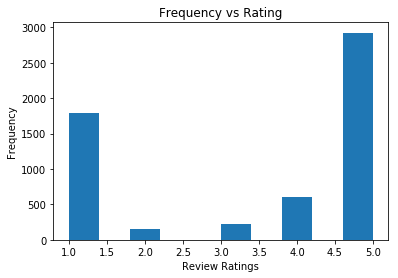

In [14]:
# plotting the histogram of rating column
plt.hist(train_df['Star Rating'])
plt.xlabel('Review Ratings')
plt.ylabel('Frequency')
plt.title('Frequency vs Rating')
plt.show()


**this dataset clearly suffers from class imbalance problem, also indicates the 
customers are either too satisfied or too disappointed**

In [15]:
# exploring the app version code with rating
train_app_df = train_df.groupby('App Version Code')
train_app_df = train_app_df.agg('mean')


In [16]:
# app versions with top rating
train_app_df = train_app_df.reset_index().drop('App Version Name',axis=1)
train_app_df.head()

,App Version Code,Star Rating
0,1.0,4.750000
1,2.0,3.800000
2,9.0,4.333333
3,10.0,3.833333
4,11.0,3.238095


In [17]:
# top 10 app versions with best mean star rating
train_app_df.sort_values('Star Rating',inplace = True)
print(train_app_df['App Version Code'].iloc[-9:])

8     18.0
0      1.0
14    34.0
5     13.0
6     14.0
7     17.0
10    29.0
45    72.0
13    33.0
Name: App Version Code, dtype: float64


In [18]:
# top 10 app versions with worst mean star rating
print(train_app_df['App Version Code'].iloc[:9])

21    42.0
20    40.0
18    38.0
24    45.0
22    43.0
9     28.0
15    35.0
25    46.0
32    56.0
Name: App Version Code, dtype: float64


In [19]:
# exploring the text of top 10 best app versions excluding the stop words
def common_words_extractor(text_list):
    words_counter = collections.Counter([word.lower() for sentence in text_list for word in sentence.split() if word not in STOP_WORDS])
    print('10 Most common words in the text are:')
    print('"' + '" "'.join(list(zip(*words_counter.most_common(10)))[0]) + '"')

best_text_list=train_df[train_df['App Version Code'].isin(train_app_df['App Version Code'].iloc[-9:])]['Review Text']
common_words_extractor(best_text_list)

10 Most common words in the text are:
"app" "i" "really" "would" "services" "great" "works" ":)" "going" "good"


In [20]:
# exploring the text of top 10 worst app versions excluding the stop words
STOP_WORDS.add('.')
worst_text_list=train_df[train_df['App Version Code'].isin(train_app_df['App Version Code'].iloc[:9])]['Review Text']
common_words_extractor(worst_text_list)

10 Most common words in the text are:
"app" "i" "recharge" "niki" "bill" "use" "get" "payment" "money" "good"


**Perhaps the problem with worst performing app versions was while payments and money lost**

**Let's dig deeper into the whole review text**

In [21]:
# exploring the whole review text column
common_words_extractor(train_df[train_df['Review Text'].notnull()]['Review Text'])

10 Most common words in the text are:
"app" "i" "good" "recharge" "nice" "bill" "use" "niki" "payment" "very"


In [22]:
def generate_word_cloud(text_series):
    text_corpus=''
    for sentence in text_series:
        for word in sentence.split():
            text_corpus = text_corpus + ' ' + word.lower()
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white', 
                    stopwords = STOP_WORDS,
                    min_font_size = 10).generate(text_corpus)
    #print(text_corpus)
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

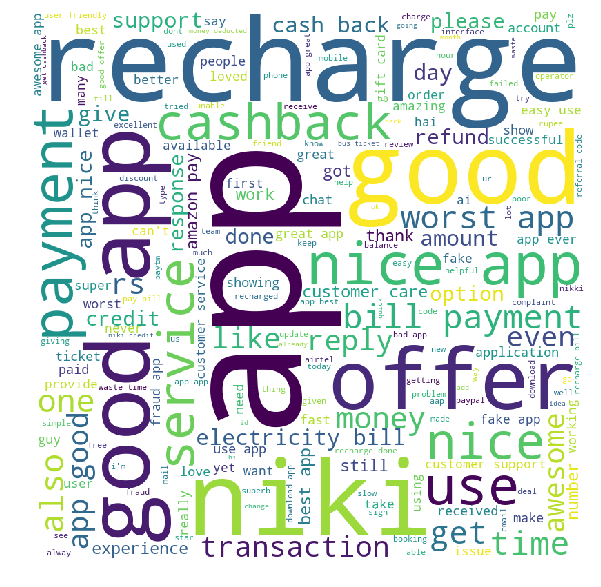

In [23]:
#word cloud of the whole text
generate_word_cloud(train_df[train_df['Review Text'].notnull()]['Review Text'])

**Overall the sentiment seems to be positive, as most of the reviews have positive words like good,nice,awesome. The customers seem to love the cashback offers which is obvious.**

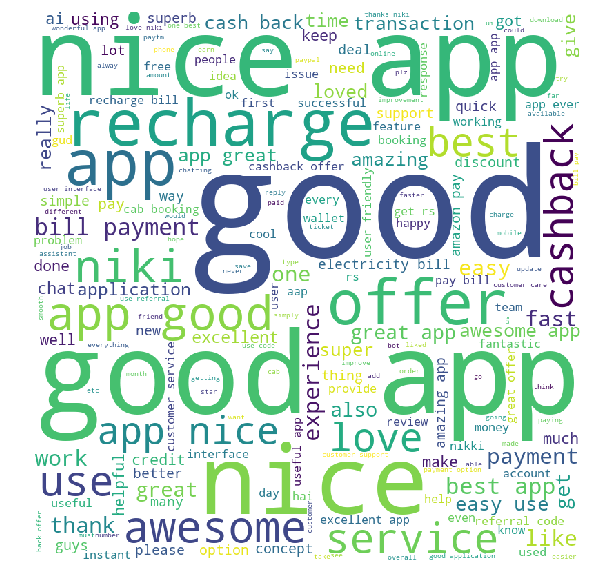

In [24]:
# word cloud of text with positive reviews(I am considering reviews with ratings 5 & 4 as positive reviews)
train_positive_df=train_df[train_df['Star Rating'].notnull()]
train_positive_df = train_positive_df[train_positive_df['Star Rating']>=4]
generate_word_cloud(train_positive_df['Review Text'])

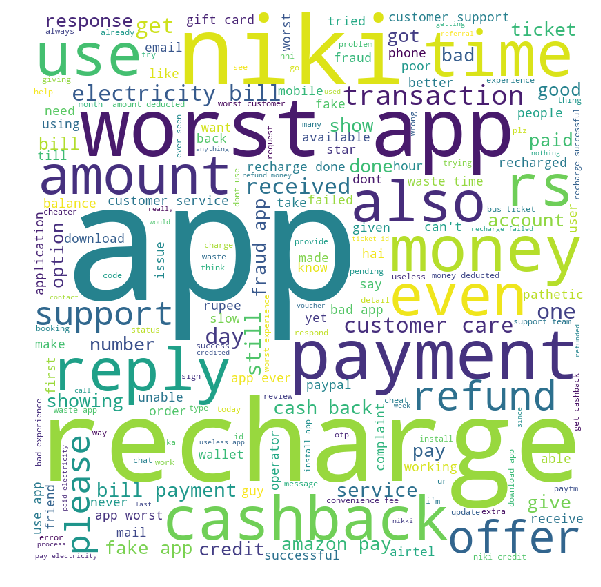

In [25]:
# word cloud of text with negative reviews(I am considering reviews with ratings 1 & 2 as negative reviews)
train_negative_df=train_df[train_df['Star Rating'].notnull()]
train_negative_df = train_negative_df[train_negative_df['Star Rating']<=2]
generate_word_cloud(train_negative_df['Review Text'])

**problems with transaction failure seems to be a factor for indignant feeling among the customers**